# Problem Statement

Whether out at a restaurant or buying tickets to a concert, modern life counts on the convenience of a credit card to make daily purchases. It saves us from carrying large amounts of cash and also can advance a full purchase that can be paid over time. How do card issuers know we’ll pay back what we charge? That’s a complex problem with many existing solutions—and even more potential improvements, to be explored in this competition.

Credit default prediction is central to managing risk in a consumer lending business. Credit default prediction allows lenders to optimize lending decisions, which leads to a better customer experience and sound business economics. Current models exist to help manage risk. But it's possible to create better models that can outperform those currently in use.

American Express is a globally integrated payments company. The largest payment card issuer in the world, they provide customers with access to products, insights, and experiences that enrich lives and build business success.

In this competition, you’ll apply your machine learning skills to predict credit default. Specifically, you will leverage an industrial scale data set to build a machine learning model that challenges the current model in production. Training, validation, and testing datasets include time-series behavioral data and anonymized customer profile information. You're free to explore any technique to create the most powerful model, from creating features to using the data in a more organic way within a model.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import catboost as cb
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import gc
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb

In [2]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Path to Feather Files
#ftrpath = "/kaggle/input/parquet-files-amexdefault-prediction"

#Path to CSV Files
#csvpath = "/kaggle/input/amex-default-prediction"

In [5]:
# Path to Feather Files
ftrpath = "/Users/akansha/Documents/Data Science/Kaggle Competitions/American Express/amex-default-prediction"

#Path to CSV Files
csvpath = "/Users/akansha/Documents/Data Science/Kaggle Competitions/American Express/amex-default-prediction"

In [6]:

def import_train_data():
        
    """
    Imports Training dataset and prints the shape, Information and Unique Customers
    :return train_data : Training dataset
    """
   
    train_data = pd.read_feather(ftrpath + '/train_data.ftr')
    print("**************Shape of Dataset***********************")
    print(train_data.shape)
    print("*****************************************************")
    print("**************Information about Dataset**************")
    print(train_data.info(verbose=True))
    print("**************Unique Customers***********************")
    print(f'Number of unique customers: {train_data["customer_ID"].nunique()}')
    return train_data

def import_test_data():
    
    """
    Imports Test dataset and prints the shape, Information and Unique Customers
    :return test_data : Test dataset
    """
   
    test_data = pd.read_feather(ftrpath + '/test_data.ftr')
    print("**************Shape of Dataset***********************")
    print(test_data.shape)
    print("*****************************************************")
    print("**************Information about Dataset**************")
    print(test_data.info(verbose=True))
    print("**************Unique Customers***********************")
    print(f'Number of unique customers: {test_data["customer_ID"].nunique()}')
    return test_data

def describe_data(data: pd.DataFrame):
    
    """
    Returns the descriptive statistics of the dataset
    :param data: Dataset for which summary statistics needs to be calculated
    :return : Summary statistics of the Dataframe provided.
    """
   
    return(data.describe(include='all').T)

def missing_values(data: pd.DataFrame) -> pd.DataFrame:

     
    """
    Creates a DataFrame with following details for each feature:
    Total Missing Values
    Percentage of Missing values
    No of Unique values
    :param data: Dataset for which missing values needs to be calculated
    :return missing_data : Top 40 features with highest percentage of missing values.
    """
    
    total_missing_values = data.isnull().sum().sort_values(ascending=False)
    percent_missing_values = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total_missing_values, percent_missing_values], axis=1, keys=['Total','Percent'])
    missing_data['Uniques'] = data.nunique().values
    return(missing_data.head(40))

def correlation_values(data: pd.DataFrame,count:int=30) -> pd.DataFrame:
    """
    Creates a DataFrame which contains the correlation between features in the dataset
    It contains following details
    Feature 1
    Feature 2
    CORRELALTION - Correlation between the two features
    CORR_ABS -  Absolute value of correlation
    :param data: Dataset for which correlation needs to be calculated
    :param count: No of rows to be returned. Default value is set as 30
    :return corr_df : Top "count" correlation in the dataset.
    """
    train_data_corr =  data.corr(method='pearson')
    corr=train_data_corr.where(np.triu(np.ones(train_data_corr.shape),k=1).astype(np.bool))
    corr_df=corr.unstack().reset_index()

    corr_df.columns = ['Variable1','Variable2','CORRELATION']
    corr_df['CORR_ABS'] = abs(corr_df['CORRELATION'])
    return(corr_df.sort_values('CORR_ABS', ascending=False).head(count))


In [7]:
def categorical_plot(data:pd.DataFrame, feature: str,xticks:int=0):
    
    """
    It is used to plot the distribution of feature with respect to target variable
    - Total percentage for each category in feature
    - Percentage of Defaulters for each category in feature
    - Percentage of Non Defaulters for each category in feature
    """
    
    fig, axs = plt.subplots(1,3,figsize=(20,6))
    feature_target_1_percentage = ((data[data.target == 1][feature].value_counts().sort_values(ascending=False) / data[feature].value_counts().sort_values(ascending=False))*100).round(2)
    feature_target_0_percentage = ((data[data.target == 0][feature].value_counts().sort_values(ascending=False) / data[feature].value_counts().sort_values(ascending=False))*100).round(2)
    total_percentage = ((data[feature].value_counts().sort_values(ascending=False) / data.shape[0])*100).round(2)
    
    axs[0].set(xlabel=feature, ylabel='Total Percentage')
    sns.barplot(x= total_percentage.index,y=total_percentage.values,ax=axs[0]).set_title("Distribution based on "+feature)
    
    sns.barplot(x= feature_target_0_percentage.index,y=feature_target_0_percentage.values,ax=axs[1]).set_title(feature+" by Non Defaulter")
    axs[1].set(xlabel=feature, ylabel='Percentage of Non Defaulters')
    sns.barplot(x= feature_target_1_percentage.index,y=feature_target_1_percentage.values,ax=axs[2]).set_title(feature+" by Defaulter")
    plot3 =axs[2].set(xlabel=feature, ylabel='Percentage of Defaulters')
    def autolabel(rects):
      for rect in rects:
          height = rect.get_height()
          if height>0:
            ax.text(rect.get_x()+0.2, rect.get_height()/2,height,
                    ha='center', va='bottom', rotation=90, color='black',size=12,family='serif',style="normal",weight="light")
    for ax in axs.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(xticks)
            autolabel(ax.patches)

    plt.show()
    
def target_plot(data: pd.DataFrame):
    
    """
    This method is used to plot a pie chart which shows distribution of target variable
    :param data: Dataset which contains the target variable
    """
    
    column = data['target'].value_counts(normalize=True)
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.keys()
    plt.pie(x=column, autopct="%.1f%%", labels=labels, pctdistance=0.5,explode=[0.05]*2)
    plt.title(" Distribution of Target variable", fontsize=14);
    
def statements_per_customer_plot(data: pd.DataFrame):
    
    """
    This method is used to plot a pie chart which shows number of statements for customers in the dataset
    :param data: Dataset for which the statement counts need to be plotted
    """
    
    column = data.customer_ID.value_counts().value_counts().sort_index(ascending=False)
    pie, ax = plt.subplots(figsize=[10,8])
    labels = column.keys()
    plt.pie(x=column, labels=labels, pctdistance=0.5)
    plt.title(" Distribution of Statements per Customer", fontsize=14);

In [8]:
def process_and_feature_engineer(data: pd.DataFrame) -> pd.DataFrame:
    
    """
    This method is used to feature engineer the dataset
    For categorical features we aggregate the values for each customer ID and calculate count, last and nunique values
    For numerical features we aggregate the values for each customer ID and calculate mean, std, min, max, last
    :param data: Dataset to feature engineer
    :returns df: Dataset after Feature Engineering
    """
    
    features = [f for f in list(data.columns) if f not in ['customer_ID','S_2','target']]
    cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
    num_features = [feature for feature in features if feature not in cat_features]

    df_num_agg = data.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last','first'])
    df_num_agg.columns = ['_'.join(x) for x in df_num_agg.columns]
    
   
     
    for col in num_features:
        
        #df_num_agg[f'{col}_last_mean_diff'] = df_num_agg[f'{col}_last'] - df_num_agg[f'{col}_mean']
        df_num_agg[f'{col}_last_first_diff'] = df_num_agg[f'{col}_last'] - df_num_agg[f'{col}_first']


    
      # Transform float64 columns to float32
    cols = list(df_num_agg.dtypes[df_num_agg.dtypes == 'float64'].index)
    for col in cols:
        df_num_agg[col] = df_num_agg[col].astype(np.float32)
    # Transform int64 columns to int32
    cols = list(df_num_agg.dtypes[df_num_agg.dtypes == 'int64'].index)
    for col in cols:
        df_num_agg[col] = df_num_agg[col].astype(np.int32)
    
    df_cat_agg = data.groupby("customer_ID")[cat_features].agg(['count', 'last','first','nunique'])
    df_cat_agg.columns = ['_'.join(x) for x in df_cat_agg.columns]
    #df_cat_agg.fillna("NONE",inplace=True)
    df_cat_agg = df_cat_agg.fillna("None")
    df = pd.concat([df_num_agg, df_cat_agg], axis=1)
    del df_num_agg, df_cat_agg
    num_cols = list(df.dtypes[(df.dtypes == 'float32') | (df.dtypes == 'float64')].index)
    for col in num_cols:
         df[col] = df[col].round(2)
    return df
    print('shape after engineering', df.shape )


In [9]:
def amex_metric(y_true: pd.DataFrame, y_pred:pd.DataFrame) -> float:
    
    """
    This method calculated the evaluation metric for this competition. It is the mean of two measures of rank ordering: 
    Normalized Gini Coefficient 𝐺
    and default rate captured at 4%, 𝐷

    𝑀=0.5⋅(𝐺+𝐷)
    
    The default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.
    :param y_true : target values provided for training
    :param y_pred : Predicted values
    :return amex_metric: metric used in this competition
    
    """
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)

### Reading and understanding data

In [10]:
#Importing the training dataset
train_data = import_train_data()

**************Shape of Dataset***********************
(5531451, 190)
*****************************************************
**************Information about Dataset**************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #   Column       Dtype   
---  ------       -----   
 0   customer_ID  object  
 1   S_2          object  
 2   P_2          float16 
 3   D_39         float16 
 4   B_1          float16 
 5   B_2          float16 
 6   R_1          float16 
 7   S_3          float16 
 8   D_41         float16 
 9   B_3          float16 
 10  D_42         float16 
 11  D_43         float16 
 12  D_44         float16 
 13  B_4          float16 
 14  D_45         float16 
 15  B_5          float16 
 16  R_2          float16 
 17  D_46         float16 
 18  D_47         float16 
 19  D_48         float16 
 20  D_49         float16 
 21  B_6          float16 
 22  B_7          float16 
 23  B_8          float16 
 24  D_

In [11]:
# First 5 items in the training dataset
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,CR,O,0.007126,0.007664,NaN,0.652832,0.008522,NaN,0.004730,6.0,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,0.069092,NaN,0.004326,0.007561,NaN,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0.0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,1.004883,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2.0,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1.0,0.238281,0.0,4.0,0.232178,0.236206,0.0,0.702148,0.434326,0.003057,0.686523,0.008743,1.0,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,CR,O,0.002413,0.007149,NaN,0.646973,0.002237,NaN,0.003880,6.0,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,0.074158,NaN,0.004204,0.005302,NaN,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0.0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,1.003906,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2.0,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1.0,0.247192,0.0,4.0,0.243530,0.241943,0.0,0.707031,0.430420,0.001306,0.686523,0.000755,1.0,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.

In [12]:
# Summary statistics for training dataset
#describe_data(train_data)

### Missing Values

In [13]:
#missing_values(train_data)

In [14]:
test_data = import_test_data()

**************Shape of Dataset***********************
(11363762, 190)
*****************************************************
**************Information about Dataset**************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11363762 entries, 0 to 11363761
Data columns (total 190 columns):
 #   Column       Dtype   
---  ------       -----   
 0   customer_ID  object  
 1   S_2          object  
 2   P_2          float16 
 3   D_39         float16 
 4   B_1          float16 
 5   B_2          float16 
 6   R_1          float16 
 7   S_3          float16 
 8   D_41         float16 
 9   B_3          float16 
 10  D_42         float16 
 11  D_43         float16 
 12  D_44         float16 
 13  B_4          float16 
 14  D_45         float16 
 15  B_5          float16 
 16  R_2          float16 
 17  D_46         float16 
 18  D_47         float16 
 19  D_48         float16 
 20  D_49         float16 
 21  B_6          float16 
 22  B_7          float16 
 23  B_8          float16 
 24 

### Exploratory Data Analysis

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables
S_* = Spend variables
P_* = Payment variables
B_* = Balance variables
R_* = Risk variables
with the following features being categorical:

['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

#### Feature Distribution - No of Deliquency, Spend, Payment, Risk and Balance Features in the dataset

In [15]:
features_Delinquency = [f for f in train_data.columns if f.startswith('D_')]
features_Spend = [f for f in train_data.columns if f.startswith('S_')]
features_Payment = [f for f in train_data.columns if f.startswith('P_')]
features_Balance = [f for f in train_data.columns if f.startswith('B_')]
features_Risk = [f for f in train_data.columns if f.startswith('R_')]
print(f'Total number of Delinquency variables: {len(features_Delinquency)}')
print(f'Total number of Spend variables: {len(features_Spend)}')
print(f'Total number of Payment variables: {len(features_Payment)}')
print(f'Total number of Balance variables: {len(features_Balance)}')
print(f'Total number of Risk variables: {len(features_Risk)}')

Total number of Delinquency variables: 96
Total number of Spend variables: 22
Total number of Payment variables: 3
Total number of Balance variables: 40
Total number of Risk variables: 28


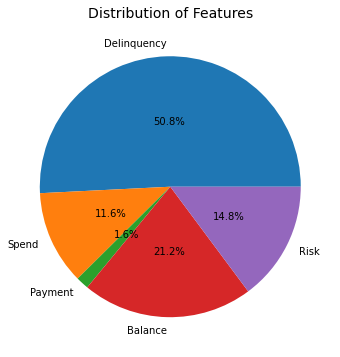

In [16]:
column = [len(features_Delinquency),len(features_Spend),len(features_Payment),len(features_Balance),len(features_Risk)]
pie, ax = plt.subplots(figsize=[10,6])
labels = ['Delinquency','Spend','Payment','Balance','Risk']
plt.pie(x=column, autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Distribution of Features", fontsize=14);

#### Target Variable

In [17]:
train_labels = pd.read_csv(csvpath + '/train_labels.csv')

In [18]:
train_labels.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [19]:
train_data = pd.merge(train_data, train_labels, how='inner', on = 'customer_ID')

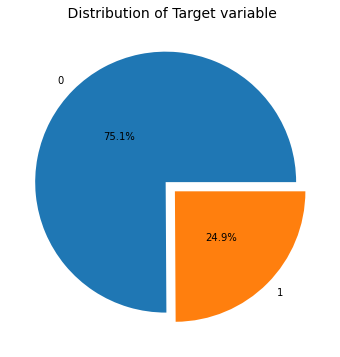

In [20]:
target_plot(train_data)

#### Converting S_2 into datetime column

In [21]:
train_data['S_2']= pd.to_datetime(train_data['S_2'])

#### Analyzing Categorical columns

In [22]:
categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in categorical_columns:
    train_data[col] = train_data[col].astype(str)

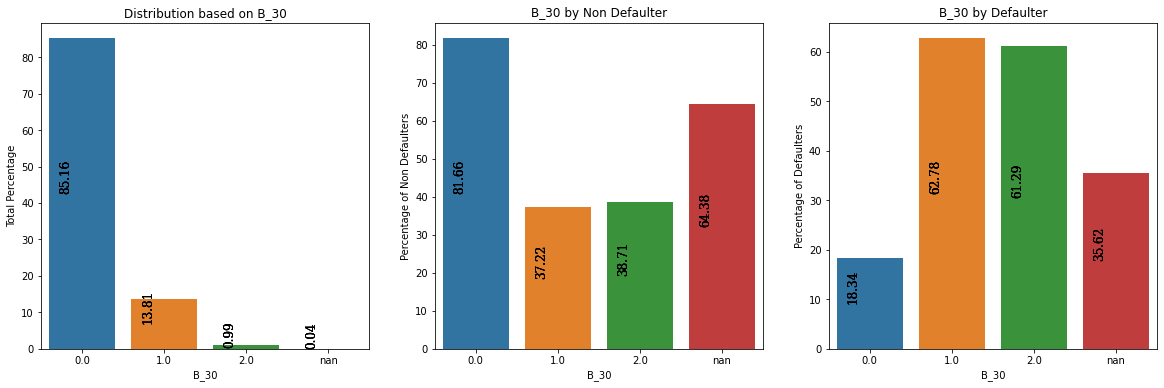

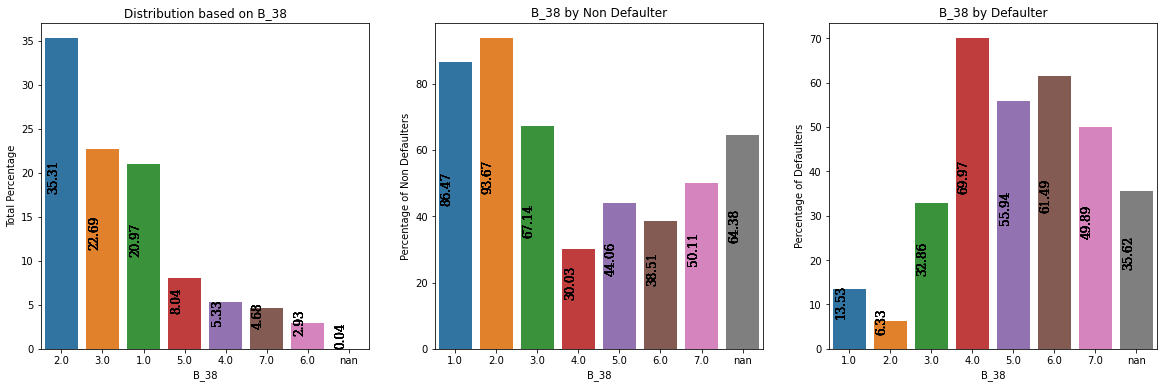

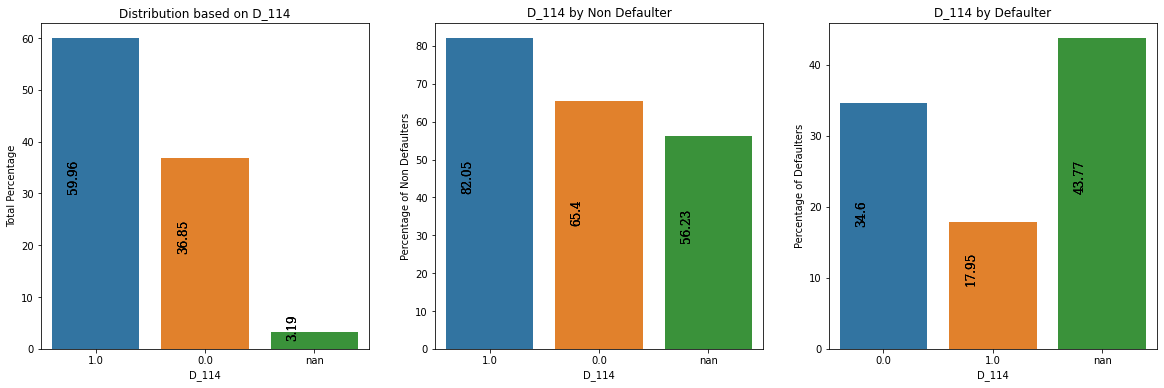

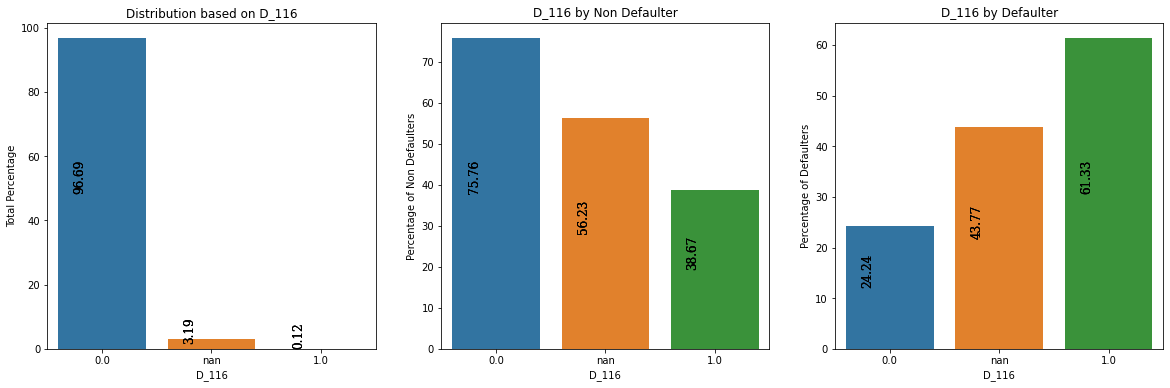

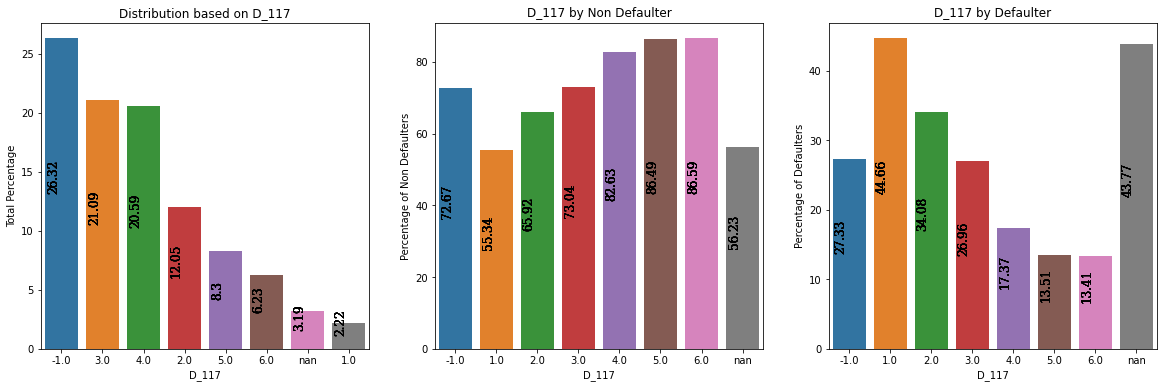

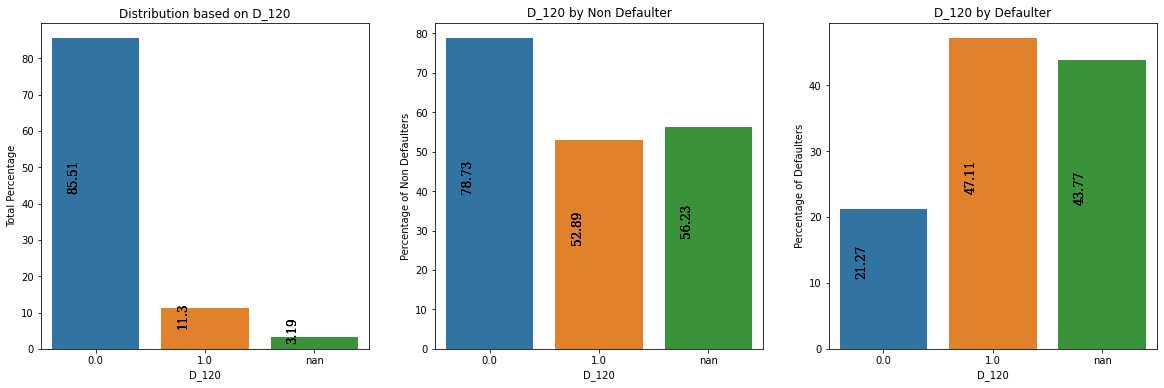

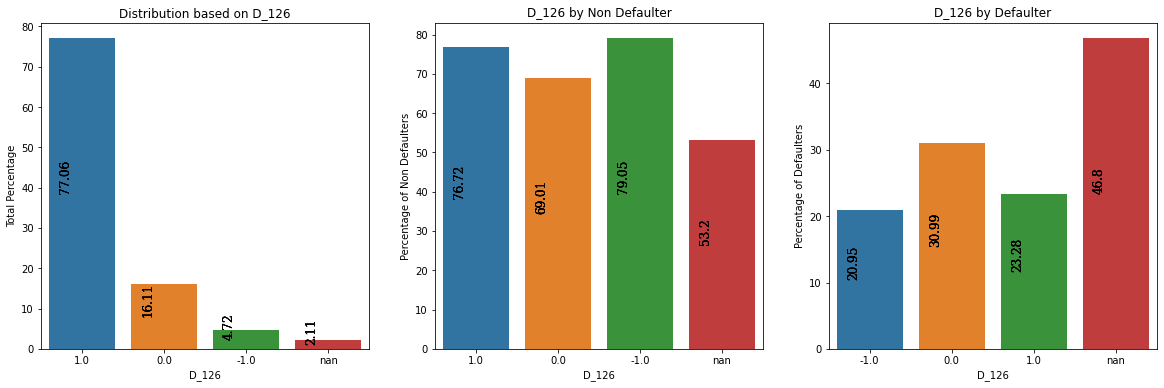

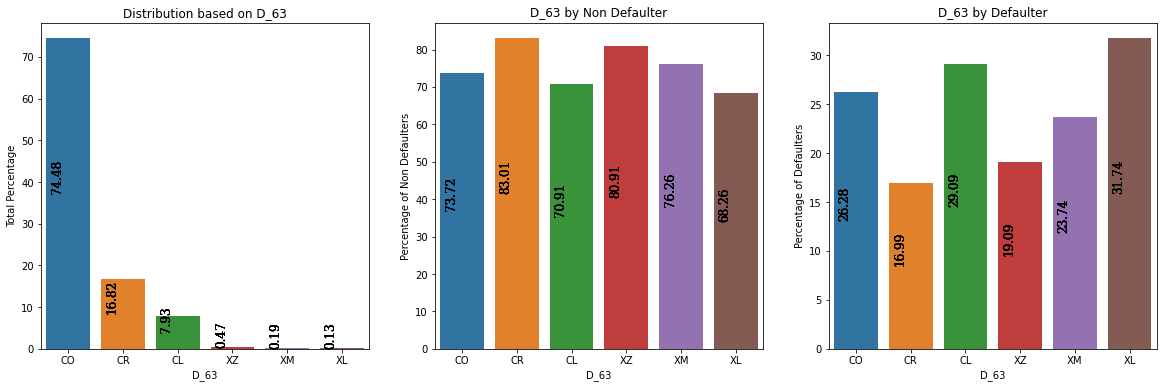

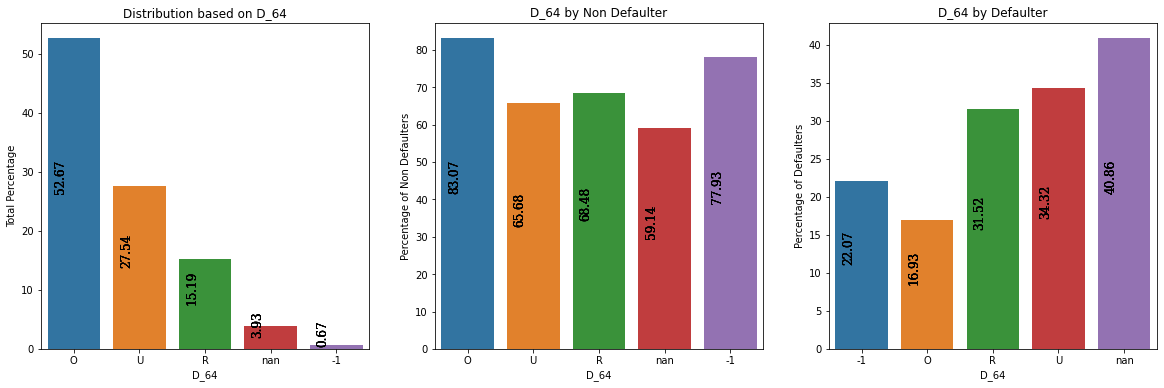

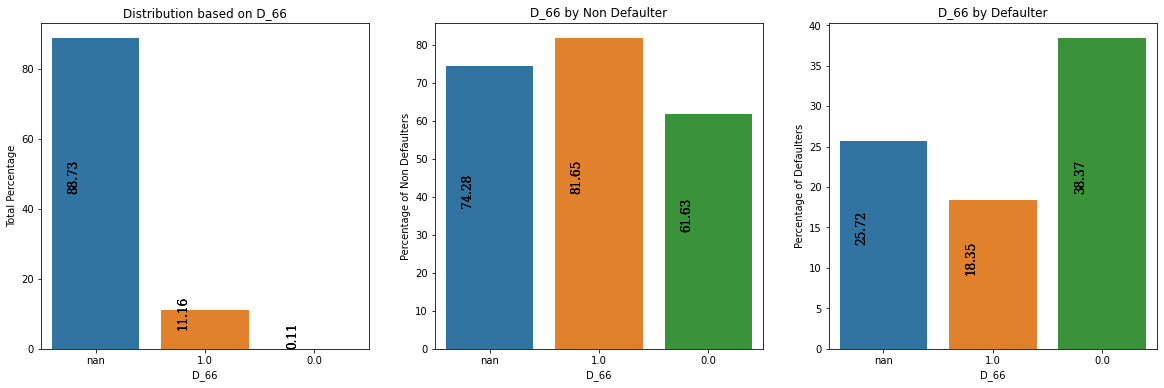

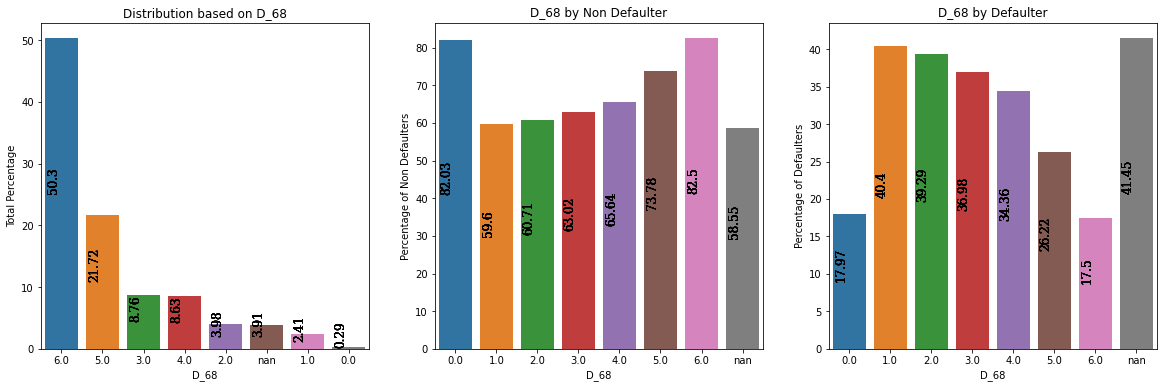

In [23]:
for col in categorical_columns:
    categorical_plot(train_data,col)

#### No of statements per customer

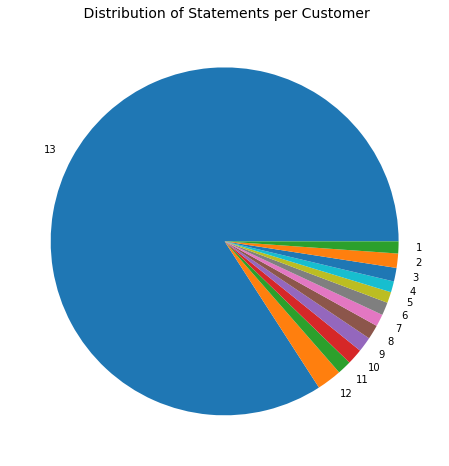

In [24]:
statements_per_customer_plot(train_data)

Around 84% customers have 13 statements

In [25]:
tempcols = []
for i in train_data.columns:
    if train_data[i].nunique() <= 2:
        tempcols.append(i)
print(tempcols)

['D_87', 'B_31', 'target']


In [26]:
train_data[tempcols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5531451 entries, 0 to 5531450
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   D_87    float16
 1   B_31    int64  
 2   target  int64  
dtypes: float16(1), int64(2)
memory usage: 137.2 MB


B_31 and D_87 have binary values.B_31 is always 0 or 1.
D_87 is 1 or missing values

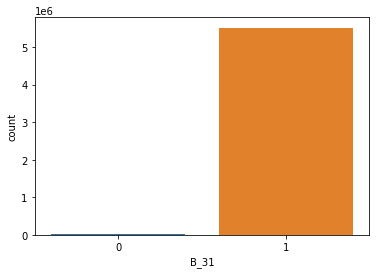

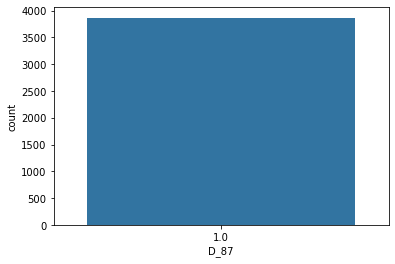

In [27]:
for col in ['B_31','D_87']:
    sns.countplot(data=train_data, x=col)
    plt.show()

### Delinquency Features

In [28]:
describe_data(train_data[features_Delinquency])

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
D_39,5.53145e+06,NaN,NaN,NaN,NaN,0,0,0.00452805,0.00905609,0.236694,5.39062
D_41,5.52944e+06,NaN,NaN,NaN,NaN,0,0,0.00287247,0.00574493,0.00861359,8.99219
D_42,791314,NaN,NaN,NaN,NaN,0,-0.000454426,0.0375061,0.120544,0.250977,4.19141
D_43,3.87306e+06,NaN,NaN,NaN,NaN,0,1.19209e-07,0.0422668,0.088501,0.184326,10.1094
D_44,5.25713e+06,NaN,NaN,NaN,NaN,0,0,0.00383377,0.00766754,0.131958,5.63281
D_45,5.52943e+06,NaN,NaN,NaN,NaN,0,0,0.0546265,0.180786,0.373291,1.61035
D_46,4.31975e+06,NaN,NaN,NaN,NaN,0,-17.2969,0.425049,0.459717,0.517578,16.3125
D_47,5.53145e+06,NaN,NaN,NaN,NaN,0,-0.0266266,0.2323,0.383057,0.561523,1.64355
D_48,4.81273e+06,NaN,NaN,NaN,NaN,0,-0.00961304,0.0809937,0.286133,0.669434,8.96875
D_49,545534,NaN,NaN,NaN,NaN,0,4.76837e-07,0.0615845,0.130371,0.246704,45.8438


In [29]:
correlation_values(train_data[features_Delinquency])


,Variable1,Variable2,CORRELATION,CORR_ABS
2718,D_77,D_62,0.999780,0.999780
4399,D_104,D_103,0.999750,0.999750
7388,D_143,D_139,0.999498,0.999498
7214,D_141,D_139,0.998168,0.998168
7390,D_143,D_141,0.997691,0.997691
5455,D_119,D_118,0.994915,0.994915
2551,D_75,D_74,0.987642,0.987642
2540,D_75,D_58,0.925890,0.925890
2453,D_74,D_58,0.922569,0.922569
6423,D_132,D_131,0.879993,0.879993


<AxesSubplot:>

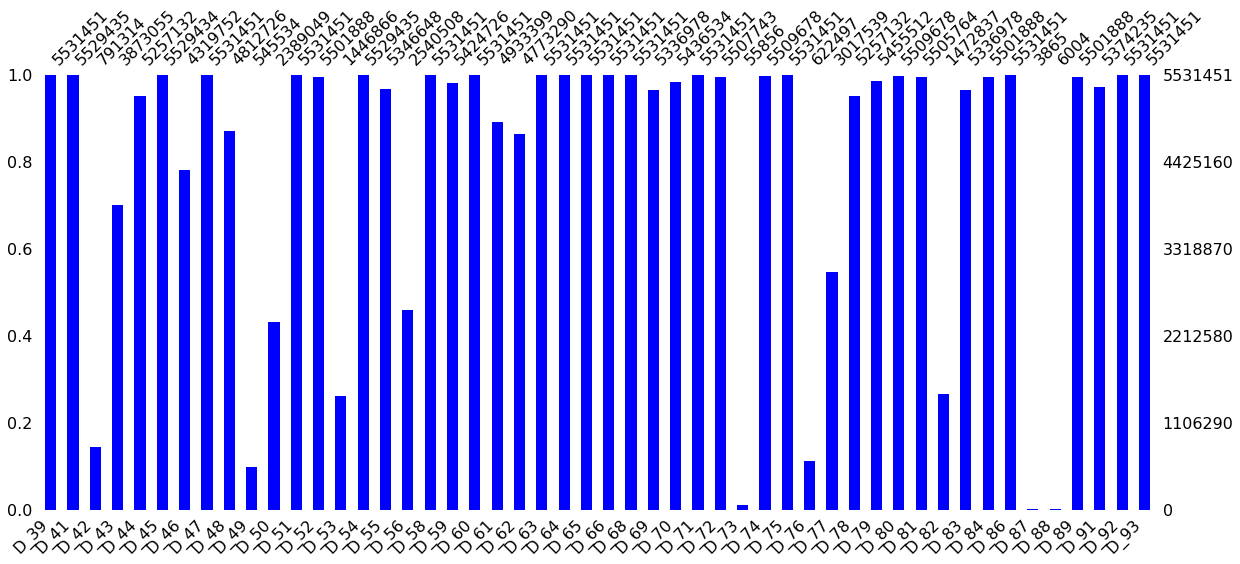

In [30]:
msno.bar(train_data[features_Delinquency[:50]],figsize=(20,8),sort="ascending", color="blue")

<AxesSubplot:>

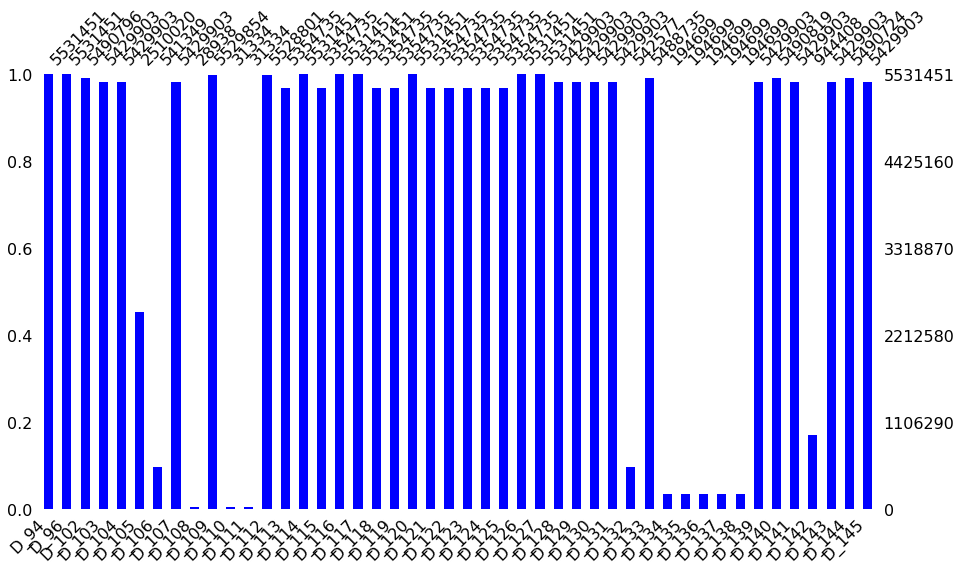

In [31]:
msno.bar(train_data[features_Delinquency[50:]],figsize=(15,8),sort="ascending", color="blue")

In [32]:
train_data.drop(columns=["D_77","D_104","D_119","D_75"],inplace=True,axis=1)
test_data.drop(columns=["D_77","D_104","D_119","D_75"],inplace=True,axis=1)

In [33]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_76,B_24,R_7,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,NaN,NaN,0.000630,0.080994,0.708984,0.170654,0.006203,0.358643,0.525391,0.255615,NaN,0.063904,0.059418,0.006466,0.148682,1.335938,0.008209,0.001423,0.207275,0.736328,0.096191,NaN,0.023376,0.002768,0.008324,1.001953,0.008301,0.161377,0.148315,0.922852,0.354492,0.151978,0.118103,0.001882,0.158569,0.065735,0.018387,0.063660,0.199585,0.308350,0.016357,0.401611,0.091064,CR,O,0.007126,0.007664,NaN,0.652832,0.008522,nan,0.004730,6.0,0.271973,0.008362,0.515137,0.002644,0.009010,0.004807,0.008339,0.119385,0.004803,0.108276,0.050873,NaN,0.007553,0.080444,NaN,0.004326,0.007561,0.007729,0.000272,0.001575,0.004238,0.001434,NaN,0.002272,0.004059,0.007122,0.002457,0.002310,0.003532,0.506836,0.008034,1.009766,0.084656,0.003820,0.007042,0.000438,0.006451,0.000830,0.005054,NaN,0.0,0.005722,0.007084,NaN,0.000198,0.008911,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002449,1.000977,0.002665,0.007481,0.006893,1.503906,1.005859,0.003569,0.008873,0.003948,0.003647,0.004951,0.894043,0.135620,0.911133,0.974609,0.001244,0.766602,1.008789,0.893555,NaN,0.669922,0.009972,0.004570,NaN,1.008789,2.0,NaN,0.004326,NaN,NaN,NaN,1.007812,0.210083,0.676758,0.007874,1.0,0.238281,0.0,4.0,0.232178,0.0,0.702148,0.434326,0.003057,0.686523,0.008743,1.0,1.002930,1.007812,1.000000,0.006805,NaN,0.002052,0.005970,NaN,0.004345,0.001534,NaN,NaN,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,NaN,NaN,0.002525,0.069397,0.712891,0.113220,0.006207,0.353516,0.521484,0.223389,NaN,0.065247,0.057739,0.001614,0.149780,1.339844,0.008369,0.001984,0.202759,0.720703,0.099792,NaN,0.030594,0.002748,0.002481,1.008789,0.005135,0.140991,0.143555,0.919434,0.326660,0.156250,0.118713,0.001610,0.148438,0.093933,0.013039,0.065491,0.151367,0.265137,0.017685,0.406250,0.086792,CR,O,0.002413,0.007149,NaN,0.646973,0.002237,nan,0.003880,6.0,0.188965,0.004028,0.509277,0.004192,0.007843,0.001283,0.006523,0.140625,0.000094,0.101013,0.040466,NaN,0.004833,0.081421,NaN,0.004204,0.005302,0.001864,0.000978,0.009895,0.007599,0.000509,NaN,0.009811,0.000126,0.005966,0.000395,0.001327,0.007774,0.500977,0.000761,1.009766,0.081848,0.000347,0.007790,0.004311,0.002333,0.009468,0.003754,NaN,0.0,0.007584,0.006676,NaN,0.001143,0.005905,NaN,1,0.008430,0.008980,0.001854,0.009926,0.005989,0.002247,1.006836,0.002508,0.006828,0.002836,1.503906,1.005859,0.000571,0.000391,0.008354,0.008850,0.003180,0.902344,0.136353,0.919922,0.975586,0.004562,0.786133,1.000000,0.906738,NaN,0.668457,0.003922,0.004654,NaN,1.002930,2.0,NaN,0.008705,NaN,NaN,NaN,1.007812,0.184082,0.822266,0.003445,1.0,0.247192,0.0,4.0,0.243530,0.0,0.707031,0.430420,0.001306,0.686523,0.000755,1.0,1.008789,1.003906,1.008789,0.004406,NaN,0.001034,0.004837,NaN,0.007496,0.004932,NaN,NaN,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575

### Spend Features

In [34]:
describe_data(train_data[features_Spend])

/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
S_2,5531451,396,2018-02-17,26715,2017-03-01,2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S_3,4.51091e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,-0.626953,0.127319,0.16394,0.258057,5.48438
S_5,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,0,0.00563431,0.0135193,0.0713501,206.875
S_6,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,0,0.00328445,0.00657272,0.00985718,1.00977
S_7,4.51091e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,-0.470215,0.09375,0.139648,0.29541,3.94922
S_8,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,0,0.00764465,0.321777,0.494873,1.23145
S_9,2.59781e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,2.98023e-07,0.00978851,0.0195007,0.0532227,2.83984
S_11,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,-0.199951,0.282471,0.289795,0.44873,3.80078
S_12,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,-0.404053,0.18689,0.190796,0.208862,175.375
S_13,5.53145e+06,NaN,NaT,NaN,NaT,NaT,NaN,0,0,0.00489426,0.00979614,0.427734,1.00977


In [35]:
correlation_values(train_data[features_Spend])


,Variable1,Variable2,CORRELATION,CORR_ABS
372,S_24,S_22,0.959319,0.959319
63,S_7,S_3,0.904635,0.904635
193,S_15,S_8,-0.786853,0.786853
172,S_13,S_8,0.695414,0.695414
174,S_13,S_11,0.480985,0.480985
189,S_15,S_3,0.471182,0.471182
86,S_8,S_6,-0.456313,0.456313
192,S_15,S_7,0.415159,0.415159
84,S_8,S_3,-0.398599,0.398599
197,S_15,S_13,-0.380495,0.380495


<AxesSubplot:>

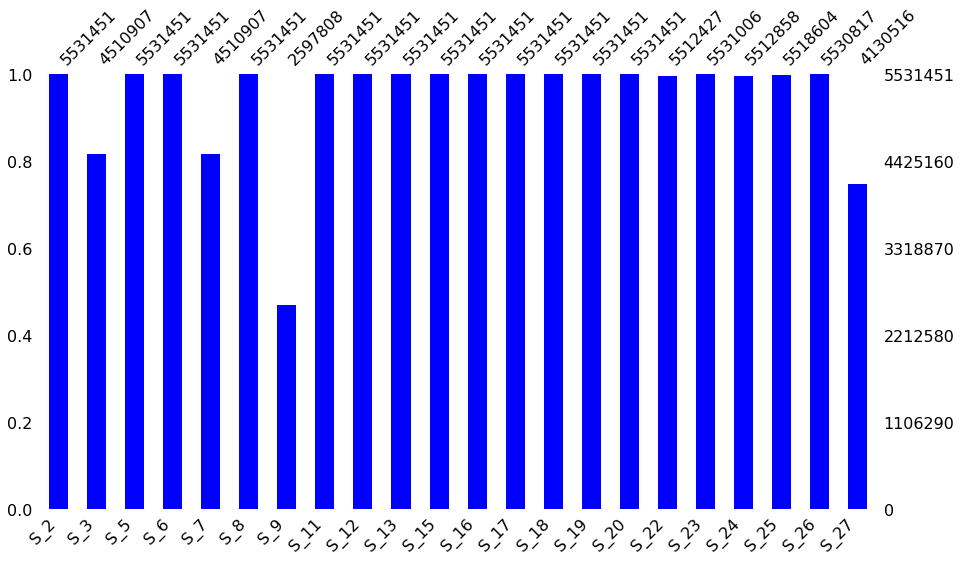

In [36]:
msno.bar(train_data[features_Spend],figsize=(15,8),sort="ascending", color="blue")

<AxesSubplot:>

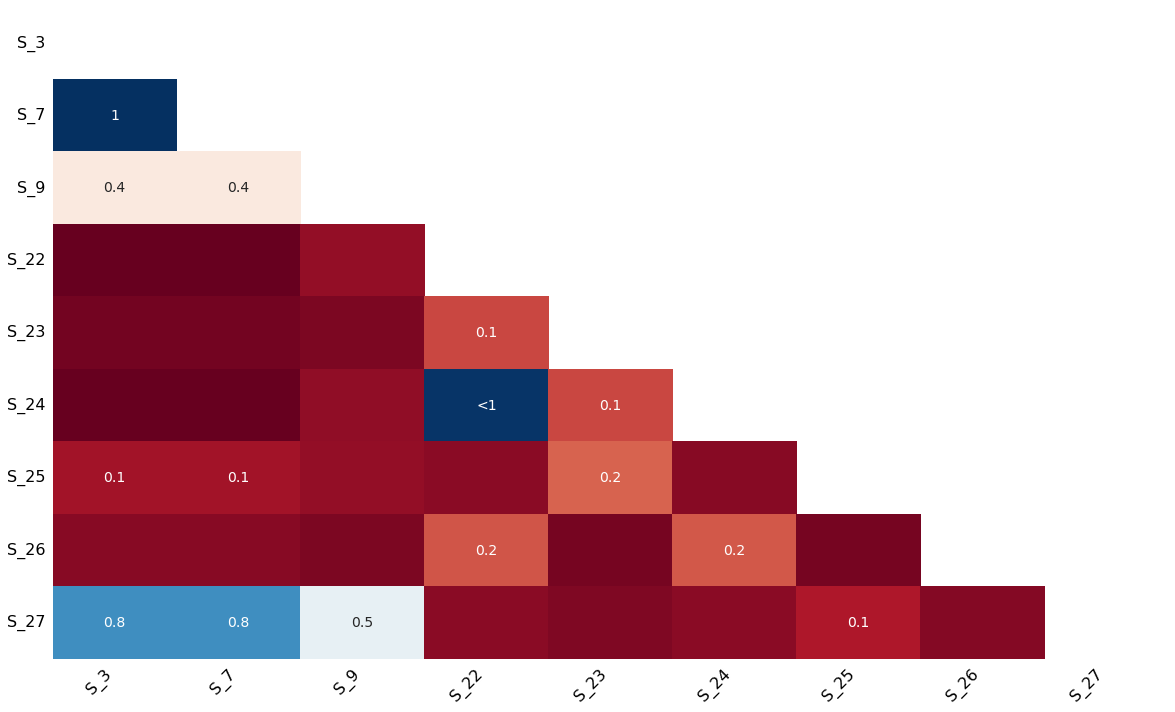

In [37]:
msno.heatmap(train_data[features_Spend])

In [38]:
train_data.drop(columns=["S_24","S_7"],inplace=True,axis=1)
test_data.drop(columns=["S_24","S_7"],inplace=True,axis=1)

### Payment Features

In [39]:
describe_data(train_data[features_Payment])

,count,mean,std,min,25%,50%,75%,max
P_2,5485466.0,NaN,0.0,-0.458984,0.480225,0.694336,0.864746,1.009766
P_3,5229959.0,NaN,0.0,-1.519531,0.541016,0.618164,0.683594,2.427734
P_4,5531451.0,NaN,0.0,0.000000,0.002924,0.005848,0.008766,1.269531


In [40]:
correlation_values(train_data[features_Payment])

,Variable1,Variable2,CORRELATION,CORR_ABS
3,P_3,P_2,0.399225,0.399225
6,P_4,P_2,-0.278898,0.278898
7,P_4,P_3,-0.104672,0.104672
0,P_2,P_2,NaN,NaN
1,P_2,P_3,NaN,NaN
2,P_2,P_4,NaN,NaN
4,P_3,P_3,NaN,NaN
5,P_3,P_4,NaN,NaN
8,P_4,P_4,NaN,NaN


<AxesSubplot:>

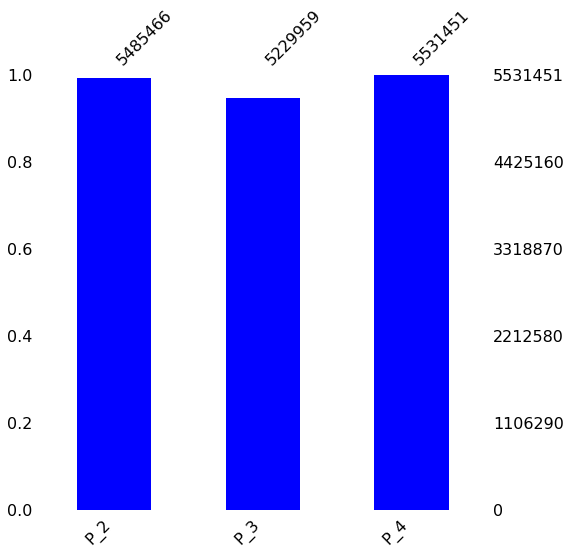

In [41]:
msno.bar(train_data[features_Payment],figsize=(8,8),sort="ascending", color="blue")

<AxesSubplot:>

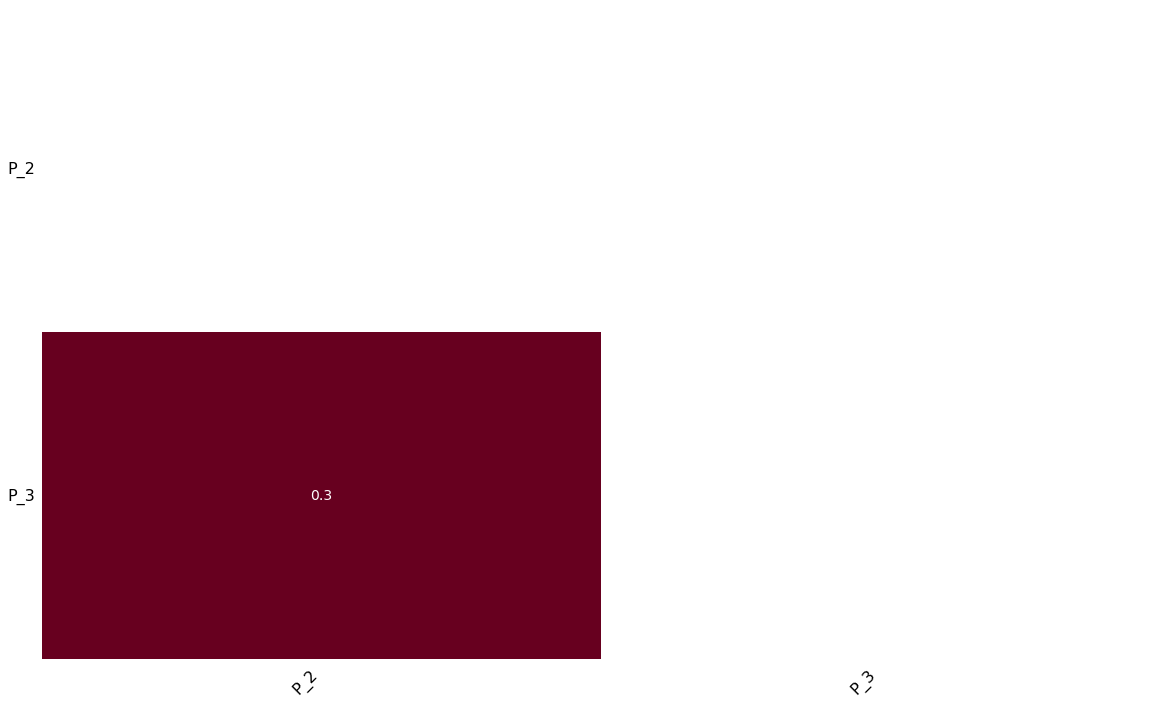

In [42]:
msno.heatmap(train_data[features_Payment])

### Risk Features

In [43]:
describe_data(train_data[features_Risk])

,count,mean,std,min,25%,50%,75%,max
R_1,5531451.0,NaN,0.0,0.000000e+00,0.002895,0.005783,0.008659,3.255859
R_2,5531451.0,NaN,0.0,0.000000e+00,0.002613,0.005222,0.007835,1.009766
R_3,5531451.0,NaN,0.0,0.000000e+00,0.004700,0.009399,0.200317,11.601562
R_4,5531451.0,NaN,0.0,0.000000e+00,0.002565,0.005131,0.007702,1.009766
R_5,5531451.0,NaN,0.0,0.000000e+00,0.002575,0.005150,0.007721,35.000000
R_6,5531451.0,NaN,0.0,0.000000e+00,0.002592,0.005188,0.007782,14.445312
R_7,5531450.0,NaN,NaN,0.000000e+00,0.002569,0.005135,0.007702,450.000000
R_8,5531451.0,NaN,0.0,0.000000e+00,0.002554,0.005104,0.007656,38.000000
R_9,312533.0,NaN,0.0,2.980232e-07,0.169067,0.172729,0.176392,1.509766
R_10,5531451.0,NaN,0.0,0.000000e+00,0.002625,0.005249,0.007866,21.000000


In [44]:
correlation_values(train_data[features_Risk])

,Variable1,Variable2,CORRELATION,CORR_ABS
200,R_8,R_5,0.791508,0.791508
85,R_4,R_2,0.778281,0.778281
340,R_13,R_5,0.686478,0.686478
663,R_24,R_20,0.678946,0.678946
115,R_5,R_4,0.672136,0.672136
28,R_2,R_1,0.637846,0.637846
84,R_4,R_1,0.629041,0.629041
199,R_8,R_4,0.626703,0.626703
173,R_7,R_6,0.593139,0.593139
252,R_10,R_1,0.579103,0.579103


<AxesSubplot:>

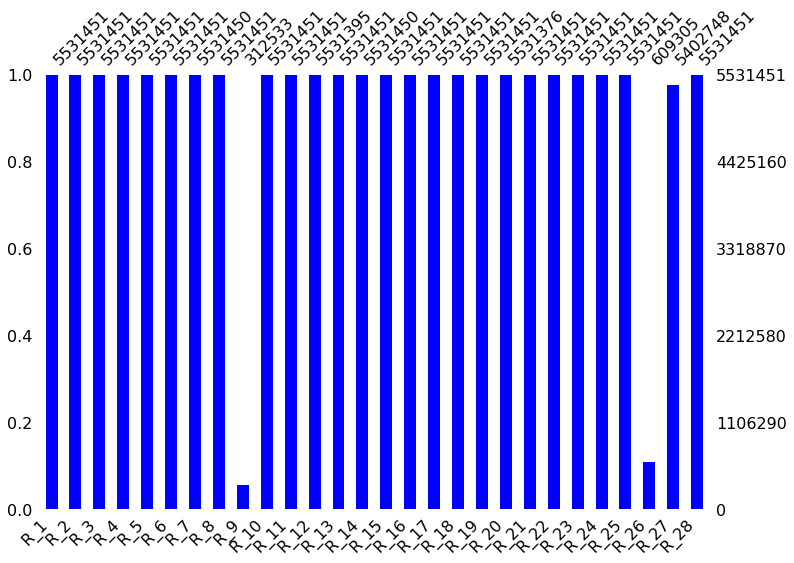

In [45]:
msno.bar(train_data[features_Risk],figsize=(12,8),sort="ascending", color="blue")

<AxesSubplot:>

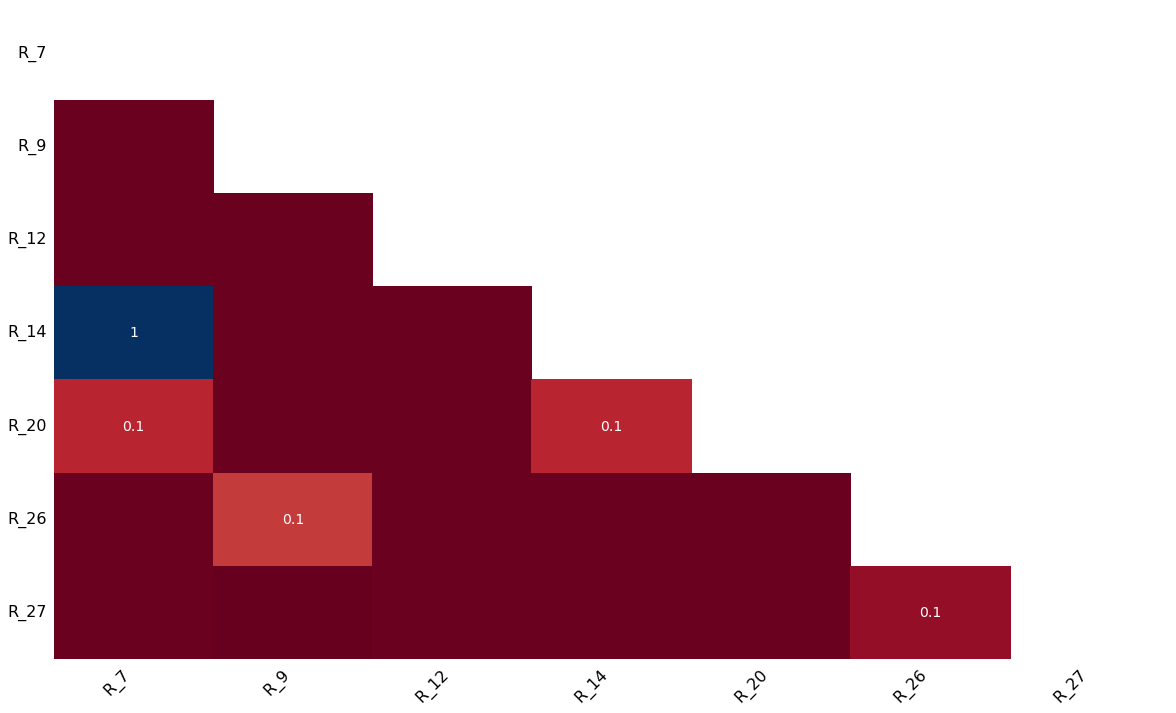

In [46]:
msno.heatmap(train_data[features_Risk])

### Balance Features

In [47]:
describe_data(train_data[features_Balance])

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
B_1,5.53145e+06,NaN,NaN,NaN,NaN,0,-7.58984,0.00886536,0.0313416,0.125854,1.32422
B_2,5.52944e+06,NaN,NaN,NaN,NaN,0,0,0.105347,0.814453,1.00195,1.00977
B_3,5.52944e+06,NaN,NaN,NaN,NaN,0,0,0.00522614,0.00978088,0.155029,1.625
B_4,5.53145e+06,NaN,NaN,NaN,NaN,0,0,0.0274963,0.0822144,0.238892,19.7969
B_5,5.53145e+06,NaN,NaN,NaN,NaN,0,0,0.00728226,0.0153732,0.0537109,144.25
B_6,5.53122e+06,NaN,NaN,NaN,NaN,NaN,-0.00517654,0.0204926,0.083374,0.191895,1215
B_7,5.53145e+06,NaN,NaN,NaN,NaN,0,-2.65234,0.028244,0.0757446,0.270996,1.25293
B_8,5.50918e+06,NaN,NaN,NaN,NaN,0,0,0.00450516,0.00901794,1.00391,1.01953
B_9,5.53145e+06,NaN,NaN,NaN,NaN,0,0,0.00575256,0.0258789,0.334229,27.4219
B_10,5.53145e+06,NaN,NaN,NaN,NaN,NaN,-0.0029583,0.0289917,0.110535,0.295654,4096


In [48]:
correlation_values(train_data[features_Balance])

,Variable1,Variable2,CORRELATION,CORR_ABS
380,B_11,B_1,0.995574,0.995574
842,B_23,B_7,0.995051,0.995051
1254,B_37,B_1,0.992915,0.992915
1264,B_37,B_11,0.987941,0.987941
1179,B_33,B_2,0.912814,0.912814
545,B_15,B_14,0.909885,0.909885
737,B_20,B_16,0.888474,0.888474
1195,B_33,B_18,0.853171,0.853171
647,B_18,B_2,0.849712,0.849712
467,B_13,B_12,0.820876,0.820876


<AxesSubplot:>

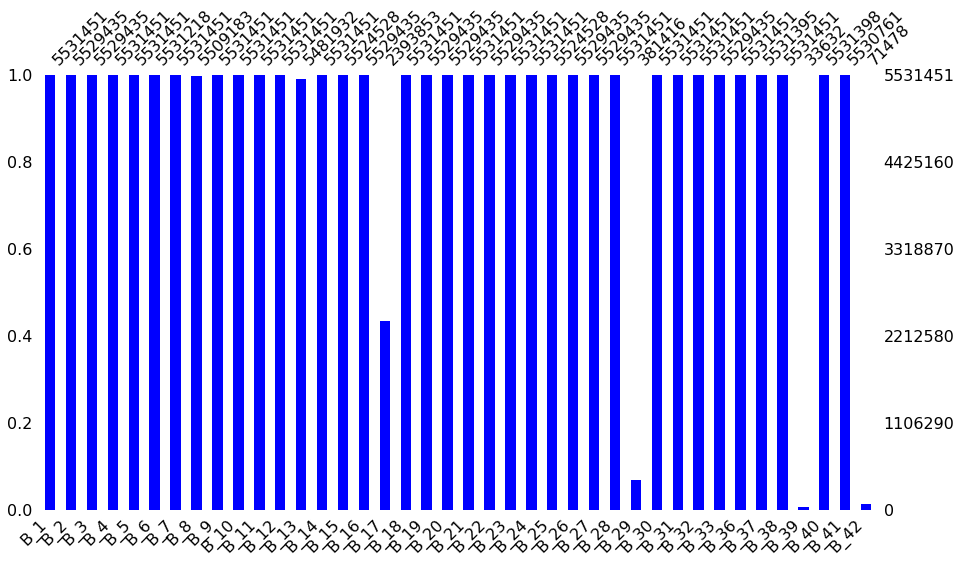

In [49]:
msno.bar(train_data[features_Balance],figsize=(15,8),sort="ascending", color="blue")

<AxesSubplot:>

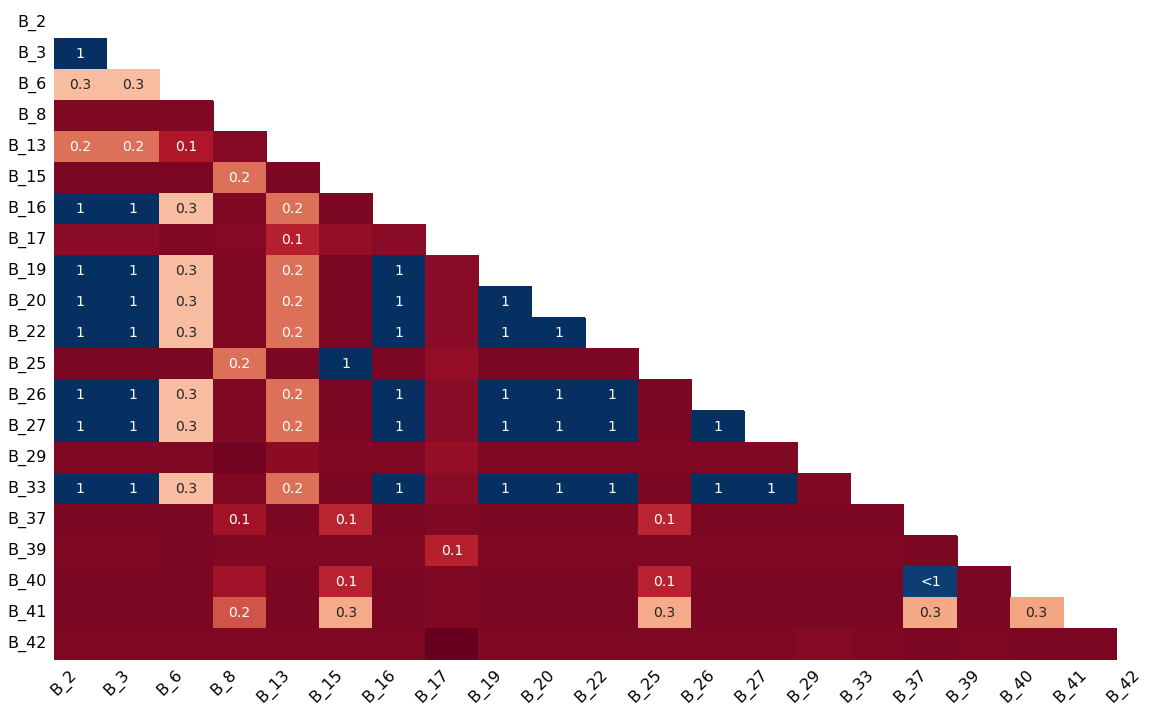

In [50]:
msno.heatmap(train_data[features_Balance])

In [51]:
train_data.drop(columns=["B_11","B_23"],inplace=True,axis=1)
test_data.drop(columns=["B_11","B_23"],inplace=True,axis=1)

### Feature Engineering

In [52]:
train_data_final = process_and_feature_engineer(train_data)





In [53]:
test_data_final = process_and_feature_engineer(test_data)





In [54]:
train_data_final.shape

(458913, 1227)

In [55]:
train_data = pd.merge(train_data_final, train_labels, how='inner', on = 'customer_ID')

In [56]:
train_data.head()

,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_2_first,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,D_39_first,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_1_first,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,B_2_first,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,R_1_first,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,S_3_first,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,D_41_first,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,B_3_first,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_42_first,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_43_first,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,D_44_first,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,B_4_first,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,D_45_first,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,B_5_first,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,R_2_first,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_46_first,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_47_first,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_48_first,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,D_49_first,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_6_first,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_7_first,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,B_8_first,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_50_first,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,D_51_first,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,B_9_first,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,R_3_first,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,D_52_first,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,P_3_first,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,B_10_first,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,D_53_first,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,S_5_first,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,S_6_first,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,D_54_first,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,R_4_first,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,B_12_first,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,S_8_first,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_55_first,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,D_56_first,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,B_13_first,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,R_5_first,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,D_58_first,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,S_9_first,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,B_14_first,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_59_first,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_60_first,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,D_61_first,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,B_15_first,S_11_mean,S_11_std,S_11_min,S_11_max,S_11_last,S_11_first,D_62_mean,D_62_std,D_62_min,D_62_max,D_62_last,D_62_first,D_65_mean,D_65_std,D_65_min,D_65_max,D_65_last,D_65_first,B_16_mean,B_16_std,B_16_min,B_16_max,B_16_last,B_16_first,B_17_mean,B_17_std,B_17_min,B_17_max,B_17_last,B_17_first,B_18_mean,B_18_std,B_18_min,B_18_max,B_18_last,B_18_first,B_19_mean,B_19_std,B_19_min,B_19_max,B_19_last,B_19_first,B_20_mean,B_20_std,B_20_min,B_20_max,B_20_last,B_20_first,S_12_mean,S_12_std,S_12_min,S_12_max,S_12_last,S_12_first,R_6_mean,R_6_std,R_6_min,R_6_max,R_6_last,R_6_first,S_13_mean,S_13_std,S_13_min,S_13_max,S_13_last,S_13_first,B_21_mean,B_21_std,B_21_min,B_21_max,B_21_last,B_21_first,D_69_mean,D_69_std,D_69_min,D_69_max,D_69_last,D_69_first,B_22_mean,B_22_std,B_22_min,B_22_max,B_22_last,B_22_first,D_70_mean,D_70_std,D_70_min,D_70_max,D_70_last,D_70_first,D_71_mean,D_71_std,D_71_min,D_71_max,D_71_last,D_71_first,D_72_mean,D_72_std,D_72_min,D_72_max,D_72_last,D_72_first,S_15_mean,S_15_std,S_15_min,S_15_max,S_15_last,S_15_first,D_73_mean,D_73_std,D_73_min,D_73_max,D_73_last,D_73_first,P_4_mean,P_4_std,P_4_min,P_4_max,P_4_last,P_4_first,D_74_mean,D_74_std,D_74_min,D_74_max,D_74_last,D_74_first,D_76_mean,D_76_std,D_76_min,D_76_max,D_76_last,D_76_first,B_24_mean,B_24_std,B_24_min,B_24_max,B_24_last,B_24_first,R_7_mean,R_7_std,R_7_min,R_7_max,R_7_last,R_7_first,B_25_mean,B_2

In [57]:
y_target = train_data['target']

In [58]:
train_data.drop(columns=["target","customer_ID"],inplace=True,axis=1)

In [59]:
train_data.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_2_first,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,D_39_first,B_1_mean,B_1_std,B_1_min,B_1_max,B_1_last,B_1_first,B_2_mean,B_2_std,B_2_min,B_2_max,B_2_last,B_2_first,R_1_mean,R_1_std,R_1_min,R_1_max,R_1_last,R_1_first,S_3_mean,S_3_std,S_3_min,S_3_max,S_3_last,S_3_first,D_41_mean,D_41_std,D_41_min,D_41_max,D_41_last,D_41_first,B_3_mean,B_3_std,B_3_min,B_3_max,B_3_last,B_3_first,D_42_mean,D_42_std,D_42_min,D_42_max,D_42_last,D_42_first,D_43_mean,D_43_std,D_43_min,D_43_max,D_43_last,D_43_first,D_44_mean,D_44_std,D_44_min,D_44_max,D_44_last,D_44_first,B_4_mean,B_4_std,B_4_min,B_4_max,B_4_last,B_4_first,D_45_mean,D_45_std,D_45_min,D_45_max,D_45_last,D_45_first,B_5_mean,B_5_std,B_5_min,B_5_max,B_5_last,B_5_first,R_2_mean,R_2_std,R_2_min,R_2_max,R_2_last,R_2_first,D_46_mean,D_46_std,D_46_min,D_46_max,D_46_last,D_46_first,D_47_mean,D_47_std,D_47_min,D_47_max,D_47_last,D_47_first,D_48_mean,D_48_std,D_48_min,D_48_max,D_48_last,D_48_first,D_49_mean,D_49_std,D_49_min,D_49_max,D_49_last,D_49_first,B_6_mean,B_6_std,B_6_min,B_6_max,B_6_last,B_6_first,B_7_mean,B_7_std,B_7_min,B_7_max,B_7_last,B_7_first,B_8_mean,B_8_std,B_8_min,B_8_max,B_8_last,B_8_first,D_50_mean,D_50_std,D_50_min,D_50_max,D_50_last,D_50_first,D_51_mean,D_51_std,D_51_min,D_51_max,D_51_last,D_51_first,B_9_mean,B_9_std,B_9_min,B_9_max,B_9_last,B_9_first,R_3_mean,R_3_std,R_3_min,R_3_max,R_3_last,R_3_first,D_52_mean,D_52_std,D_52_min,D_52_max,D_52_last,D_52_first,P_3_mean,P_3_std,P_3_min,P_3_max,P_3_last,P_3_first,B_10_mean,B_10_std,B_10_min,B_10_max,B_10_last,B_10_first,D_53_mean,D_53_std,D_53_min,D_53_max,D_53_last,D_53_first,S_5_mean,S_5_std,S_5_min,S_5_max,S_5_last,S_5_first,S_6_mean,S_6_std,S_6_min,S_6_max,S_6_last,S_6_first,D_54_mean,D_54_std,D_54_min,D_54_max,D_54_last,D_54_first,R_4_mean,R_4_std,R_4_min,R_4_max,R_4_last,R_4_first,B_12_mean,B_12_std,B_12_min,B_12_max,B_12_last,B_12_first,S_8_mean,S_8_std,S_8_min,S_8_max,S_8_last,S_8_first,D_55_mean,D_55_std,D_55_min,D_55_max,D_55_last,D_55_first,D_56_mean,D_56_std,D_56_min,D_56_max,D_56_last,D_56_first,B_13_mean,B_13_std,B_13_min,B_13_max,B_13_last,B_13_first,R_5_mean,R_5_std,R_5_min,R_5_max,R_5_last,R_5_first,D_58_mean,D_58_std,D_58_min,D_58_max,D_58_last,D_58_first,S_9_mean,S_9_std,S_9_min,S_9_max,S_9_last,S_9_first,B_14_mean,B_14_std,B_14_min,B_14_max,B_14_last,B_14_first,D_59_mean,D_59_std,D_59_min,D_59_max,D_59_last,D_59_first,D_60_mean,D_60_std,D_60_min,D_60_max,D_60_last,D_60_first,D_61_mean,D_61_std,D_61_min,D_61_max,D_61_last,D_61_first,B_15_mean,B_15_std,B_15_min,B_15_max,B_15_last,B_15_first,S_11_mean,S_11_std,S_11_min,S_11_max,S_11_last,S_11_first,D_62_mean,D_62_std,D_62_min,D_62_max,D_62_last,D_62_first,D_65_mean,D_65_std,D_65_min,D_65_max,D_65_last,D_65_first,B_16_mean,B_16_std,B_16_min,B_16_max,B_16_last,B_16_first,B_17_mean,B_17_std,B_17_min,B_17_max,B_17_last,B_17_first,B_18_mean,B_18_std,B_18_min,B_18_max,B_18_last,B_18_first,B_19_mean,B_19_std,B_19_min,B_19_max,B_19_last,B_19_first,B_20_mean,B_20_std,B_20_min,B_20_max,B_20_last,B_20_first,S_12_mean,S_12_std,S_12_min,S_12_max,S_12_last,S_12_first,R_6_mean,R_6_std,R_6_min,R_6_max,R_6_last,R_6_first,S_13_mean,S_13_std,S_13_min,S_13_max,S_13_last,S_13_first,B_21_mean,B_21_std,B_21_min,B_21_max,B_21_last,B_21_first,D_69_mean,D_69_std,D_69_min,D_69_max,D_69_last,D_69_first,B_22_mean,B_22_std,B_22_min,B_22_max,B_22_last,B_22_first,D_70_mean,D_70_std,D_70_min,D_70_max,D_70_last,D_70_first,D_71_mean,D_71_std,D_71_min,D_71_max,D_71_last,D_71_first,D_72_mean,D_72_std,D_72_min,D_72_max,D_72_last,D_72_first,S_15_mean,S_15_std,S_15_min,S_15_max,S_15_last,S_15_first,D_73_mean,D_73_std,D_73_min,D_73_max,D_73_last,D_73_first,P_4_mean,P_4_std,P_4_min,P_4_max,P_4_last,P_4_first,D_74_mean,D_74_std,D_74_min,D_74_max,D_74_last,D_74_first,D_76_mean,D_76_std,D_76_min,D_76_max,D_76_last,D_76_first,B_24_mean,B_24_std,B_24_min,B_24_max,B_24_last,B_24_first,R_7_mean,R_7_std,R_7_min,R_7_max,R_7_last,R_7_first,B_25_mean,B_25_std,B_25_m

In [60]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 458913 entries, 0 to 458912
Data columns (total 1227 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    P_2_mean               float16
 1    P_2_std                float32
 2    P_2_min                float16
 3    P_2_max                float16
 4    P_2_last               float16
 5    P_2_first              float16
 6    D_39_mean              float16
 7    D_39_std               float32
 8    D_39_min               float16
 9    D_39_max               float16
 10   D_39_last              float16
 11   D_39_first             float16
 12   B_1_mean               float16
 13   B_1_std                float32
 14   B_1_min                float16
 15   B_1_max                float16
 16   B_1_last               float16
 17   B_1_first              float16
 18   B_2_mean               float16
 19   B_2_std                float32
 20   B_2_min                float16
 21   B_2_max                float16

In [61]:
test_data_final=test_data_final.reset_index()


output= pd.DataFrame()
output['customer_ID'] = test_data_final["customer_ID"]

test_data_final.drop(columns=["customer_ID"],inplace=True,axis=1)

In [62]:
categorical_columns = categorical_columns = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

cat_features = [f"{cf}_last" for cf in categorical_columns]
cat_features.extend([f"{cf}_first" for cf in categorical_columns])
for categorical_feature in cat_features:
    
    le_encoder = LabelEncoder()
    train_data[categorical_feature] = train_data[categorical_feature].astype('str')
    train_data[categorical_feature] = train_data[categorical_feature].astype('str')
    
    le_encoder.fit(train_data[categorical_feature])
    test_data_final[categorical_feature]  = test_data_final[categorical_feature].map(lambda s: '<unknown>' if s not in le_encoder.classes_ else s)
    le_encoder.classes_ = np.append(le_encoder.classes_, '<unknown>')
    train_data[categorical_feature]  = le_encoder.transform(train_data[categorical_feature] )
    test_data_final[categorical_feature]  = le_encoder.transform(test_data_final[categorical_feature])
    

In [63]:
def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label()
    return 'amex_metric', amex_metric(y_true, y_pred), True

In [64]:
from imblearn.over_sampling import KMeansSMOTE

train_data.fillna(-1,inplace=True)
#sm = KMeansSMOTE(random_state=42)
#train_data,y_target= sm.fit_resample(train_data,y_target)

#train_data,y_target = SMOTE().fit_resample(train_data,y_target)
    
train_x, valid_x, train_y, valid_y = train_test_split(train_data,y_target, test_size=0.3,random_state=42,stratify=y_target)



### Model Training

In [65]:
def objective(trial):
    
    features = [col for col in train_data.columns if col not in ['customer_ID','S_2','target']]
   
    param = {
        "objective": 'binary',
        "metric": "binary_logloss",
        "boosting":"dart",
        "verbosity": -1,
        'boosting_type': 'gbdt',
        "learning_rate":trial.suggest_discrete_uniform("learning_rate", 0.001, 0.02, 0.001),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
       
    }

  
    lgb_train = lgb.Dataset(train_x, train_y, categorical_feature = cat_features)
    lgb_valid = lgb.Dataset(valid_x, valid_y, categorical_feature = cat_features)
    model = lgb.train(
            params = param,
            train_set = lgb_train,
            num_boost_round = 1000,
            valid_sets = [lgb_train, lgb_valid],
            verbose_eval = 100,
            feval = lgb_amex_metric
            )

    # Predict validation
    val_pred = model.predict(valid_x)
    # Compute out of folds metric
    score = amex_metric(valid_y, val_pred)
    return score

In [66]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)

[I 2022-08-09 14:09:58,354] A new study created in memory with name: no-name-701b0e22-d8b6-4ad1-a22f-d80c9aa17119
/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1551: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[100]	training's binary_logloss: 0.571444	training's amex_metric: 0.777237	valid_1's binary_logloss: 0.571782	valid_1's amex_metric: 0.760557
[200]	training's binary_logloss: 0.587001	training's amex_metric: 0.77826	valid_1's binary_logloss: 0.587492	valid_1's amex_metric: 0.761241
[300]	training's binary_logloss: 0.579408	training's amex_metric: 0.7788	valid_1's binary_logloss: 0.580095	valid_1's amex_metric: 0.762019
[400]	training's binary_logloss: 0.568649	training's amex_metric: 0.779842	valid_1's binary_logloss: 0.569546	valid_1's amex_metric: 0.762097
[500]	training's binary_logloss: 0.555938	training's amex_metric: 0.781474	valid_1's binary_logloss: 0.557072	valid_1's amex_metric: 0.762679
[600]	training's binary_logloss: 0.548782	training's amex_metric: 0.781543	valid_1's binary_logloss: 0.550034	valid_1's amex_metric: 0.762967
[700]	training's binary_logloss: 0.538702	training's amex_metric: 0.781935	valid_1's binary_logloss: 0.540146	valid_1's amex_metric: 0.763546
[800]	tra

[I 2022-08-09 14:32:27,646] Trial 0 finished with value: 0.7649290783189739 and parameters: {'learning_rate': 0.001, 'lambda_l1': 0.033939713702682645, 'lambda_l2': 1.5207373979451713e-05, 'num_leaves': 471, 'feature_fraction': 0.6088108533669476, 'bagging_fraction': 0.22082398133423595, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 0 with value: 0.7649290783189739.
/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1551: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[100]	training's binary_logloss: 0.417321	training's amex_metric: 0.815645	valid_1's binary_logloss: 0.424622	valid_1's amex_metric: 0.76706
[200]	training's binary_logloss: 0.373958	training's amex_metric: 0.824209	valid_1's binary_logloss: 0.384704	valid_1's amex_metric: 0.770685
[300]	training's binary_logloss: 0.321522	training's amex_metric: 0.833656	valid_1's binary_logloss: 0.336583	valid_1's amex_metric: 0.773417
[400]	training's binary_logloss: 0.282524	training's amex_metric: 0.842219	valid_1's binary_logloss: 0.302064	valid_1's amex_metric: 0.77549
[500]	training's binary_logloss: 0.250884	training's amex_metric: 0.851522	valid_1's binary_logloss: 0.275566	valid_1's amex_metric: 0.77719
[600]	training's binary_logloss: 0.240067	training's amex_metric: 0.858918	valid_1's binary_logloss: 0.267443	valid_1's amex_metric: 0.778972
[700]	training's binary_logloss: 0.222979	training's amex_metric: 0.868104	valid_1's binary_logloss: 0.254676	valid_1's amex_metric: 0.780211
[800]	tra

[I 2022-08-09 14:51:19,826] Trial 1 finished with value: 0.7844086970071771 and parameters: {'learning_rate': 0.011, 'lambda_l1': 0.33025907930356835, 'lambda_l2': 0.07426754580988332, 'num_leaves': 446, 'feature_fraction': 0.471127984077937, 'bagging_fraction': 0.2519135021522162, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 1 with value: 0.7844086970071771.
/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1551: UserWarning:

Using categorical_feature in Dataset.



[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/Users/akansha/opt/anaconda3/envs/tf/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[100]	training's binary_logloss: 0.386269	training's amex_metric: 0.792358	valid_1's binary_logloss: 0.390656	valid_1's amex_metric: 0.767581
[200]	training's binary_logloss: 0.339091	training's amex_metric: 0.799947	valid_1's binary_logloss: 0.345641	valid_1's amex_metric: 0.771836
[300]	training's binary_logloss: 0.290551	training's amex_metric: 0.807878	valid_1's binary_logloss: 0.300084	valid_1's amex_metric: 0.77516
[400]	training's binary_logloss: 0.258072	training's amex_metric: 0.816488	valid_1's binary_logloss: 0.270792	valid_1's amex_metric: 0.777349
[500]	training's binary_logloss: 0.234338	training's amex_metric: 0.825647	valid_1's binary_logloss: 0.251008	valid_1's amex_metric: 0.780634
[600]	training's binary_logloss: 0.226868	training's amex_metric: 0.831912	valid_1's binary_logloss: 0.245707	valid_1's amex_metric: 0.782129
[700]	training's binary_logloss: 0.215024	training's amex_metric: 0.840199	valid_1's binary_logloss: 0.237413	valid_1's amex_metric: 0.783263
[800]	t

[I 2022-08-09 15:06:55,219] Trial 2 finished with value: 0.7876049785925225 and parameters: {'learning_rate': 0.015, 'lambda_l1': 0.029566390132656897, 'lambda_l2': 0.0013838943492973164, 'num_leaves': 238, 'feature_fraction': 0.3952034372867693, 'bagging_fraction': 0.31854225094127686, 'bagging_freq': 13, 'min_child_samples': 92}. Best is trial 2 with value: 0.7876049785925225.


In [67]:
#train_data.to_feather('output/train_1.feather')


In [68]:
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
param_dist = { }
for key, value in trial.params.items():
    param_dist[key]=value
param_dist

Best trial:
  Value: 0.7876049785925225
  Params: 


{'learning_rate': 0.015,
 'lambda_l1': 0.029566390132656897,
 'lambda_l2': 0.0013838943492973164,
 'num_leaves': 238,
 'feature_fraction': 0.3952034372867693,
 'bagging_fraction': 0.31854225094127686,
 'bagging_freq': 13,
 'min_child_samples': 92}

In [ ]:
lgb_train = lgb.Dataset(train_x, train_y, categorical_feature = cat_features)
lgb_model = lgb.train(params = param_dist,train_set = lgb_train, num_boost_round = 10000,verbose_eval = 1000)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.355689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 269029
[LightGBM] [Info] Number of data points in the train set: 321239, number of used features: 1226
[LightGBM] [Info] Start training from score 0.258935


## Model Evaluation

In [ ]:
output["prediction"]=lgb_model.predict(test_data_final)

In [ ]:
output.head()

In [ ]:
output.to_csv("Submission_v1.csv",index=False)

In [ ]:
!kaggle competitions list -s amex-default-prediction

In [ ]:
!kaggle competitions submit amex-default-prediction -f Submission_v1.csv -m "V4"